# Introduction to the problem
The following scenario is purely fictional and is intended to interest people in the problem we are trying to solve.

*Assume that you are running a website where people can post reviews of drinks such as wine, beer, and spirits (whiskey, gin etc). As an administrator of the website you want to keep things transparent and the reviews objective, so you only allow the reviewers to taste and review only one kind of drink; some people will specialize only on wine, some only on beer and some only on different spirits. However, you (the administrator) are growing suspicious that there are some reviewers who are cross drinking and posting reviews for other drinks. You want to stop this behaviour but you don't want to piss off your tasters because they are good at their job, so you hire a data scientist to build an ML model to identify tasters who are cross drinking and reviewing other drinks.*

The domain we are working on is a corpus of wine and beer reviews collected from a website called [Wine Enthusiast](https://www.winemag.com/). The writers of our corpus are people who review and rate wines, beers and spirits professionally. Some of these tasters specialize on one drink (most of them in wine) and some others embrace cross drinking and delve into other beverage categories.

Let's get started!

# Problem methodology
This notebook will focus on building a machine learning model, trained on wine reviews, to recognize tasters who are cross drinking and reviewing other beverages. The model will be evaluated against a collection of beer reviews where it will try to identify tasters based on their unique style.

Based on some thorough inspection of the data, we saw that there 19 wine tasters, 2 beer tasters and 1 spirits taster. The 2 beer tasters also review wines, so they are the people we would like to identify. The problem, then, boils down to a binary classification problem. We will use the wine dataset and the spirits dataset and we will train a model to identify two categories, **wine_taster** and **spirits_taster**.

# Goal
Goal of this project:
    1. train a machine learning model on wine and spirits reviews
    2. use the model on a completly new dataset from beer reviews to identify tasters who have reviewed wines
    3. build an understanding of the features that considered to be important for this task
    4. we must know the goodness of predictions

# Implementation

## 0. Notebook details
* Datasets source: We will be using three different datasets that have been collected from the [same website](https://www.winemag.com/) but have been acquired differently. The wine reviews dataset was downloaded from [Kaggle](https://www.kaggle.com/zynicide/wine-reviews) thanks to the user zackthoutt who did all the hard work to scrape the data. The beer and spirits reviews dataset was downloaded using Zack's scrape which can be found on his [github page](https://github.com/zackthoutt/wine-deep-learning).
* Metadata: Because the data have been collected the same way, their metadata are similar.
    - country: The country that the wine is from, String
    - description: A few sentences from a sommelier describing the wine's taste, smell, look, feel. String
    * designation: The vineyard within the winery where the grapes that made the wine are from, String
    * points: The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80), Numeric
    * price: The cost for a bottle of the wine, Numeric
    * province: The province or state that the wine is from, String
    * region_1: Tthe wine growing area in a province or state (ie Napa), String
    * region_2: Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank, String
    * variety: The type of grapes used to make the wine (ie Pinot Noir), String
    * winery: The winery that made the wine, String

## 1. Imports

In [1]:
import os
import nltk
import re
import pickle
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from nltk.corpus import stopwords
from nltk.stem.porter import *
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.learning_curve import learning_curve
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords

sns.set(color_codes=True)
nlp = spacy.load('en')
%matplotlib inline

C:\Users\vasileios.vyzas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\vasileios.vyzas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [5]:
os.chdir('C://Users/vasileios.vyzas/Documents/workspace/Projects/Miscellaneous/wine_beer_exploration/')

In [7]:
spirits = pd.read_json('data/raw/spirits.json')
wine = pd.read_csv('data/raw/winemag-data-130k-v2.csv')

## 2. Preprocessing and feature selection
Given that the drinks we are working with are very different, features such as country, points, price, province etc. are not useful. Therefore, we are only interested in the description column which later will give us enough information to identify reviewers.

In [8]:
wine = wine.drop(['Unnamed: 0', 'country', 'points', 'price', 'province', 'title', 'designation', 'region_1', 'region_2', 'taster_twitter_handle', 'variety', 'winery'], axis = 1)
spirits = spirits.drop(['country', 'points', 'price', 'province', 'title', 'designation', 'region_1', 'region_2', 'taster_twitter_handle', 'variety', 'winery'], axis = 1)

In [9]:
# the wine dataset has more than 100000 rows, and using all of them for the classification
# will create an imbalanced classification problem. So we are using only 2000 wine reviews
wine_less_rows = wine.copy()
wine_less_rows = wine_less_rows[:5000]
wine_less_rows['label'] = 'wine_taster'
spirits['label'] = 'spirits_taster'

In [10]:
all_drinks = pd.concat([wine_less_rows, spirits])
all_drinks.reset_index(inplace=True)
all_drinks.drop(['taster_name', 'index'], axis=1, inplace=True)

In [11]:
all_drinks.groupby('label').describe()

description         \
                     count unique   
label                               
spirits_taster        4422   4369   
wine_taster           5000   4985   

                                                                        
                                                              top freq  
label                                                                   
spirits_taster  This rhum received six years of typical oak ba...    2  
wine_taster     This is weighty, creamy and medium to full in ...    2

In [12]:
all_drinks.drop_duplicates(subset='description', keep='last', inplace=True)

## 3. Feature engineering
As we mentioned the description column which is text data will not give us any useful information to recognize authors of wine and spirits reviews. However, we can use the individual descriptions to create features that represent the writing style and linguistic patterns the authors follow.

In [13]:
def normalize(review):
    review_letters = re.sub('[^a-zA-Z]', ' ', str(review))
    review_letters = review_letters.lower()
    return (" ".join(review_letters.split()))

In [14]:
def remove_stopwords(review):
    stop_words = set(stopwords.words('english'))
    ls = [word for word in review.split() if word not in stop_words]
    return (" ".join(ls))

In [15]:
def stemming(review):
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in review.split()]
    return (" ".join(stemmed))

In [16]:
processed_reviews = []
reviews = all_drinks['description']
for review in reviews:
    processed_reviews.append(remove_stopwords(normalize(review)))

In [17]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df = 0.95, ngram_range=(1,2))
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_reviews)

In [18]:
# features holds a list of all the words in the tfidf's vocabulary in the same order as the column in the matrix
features = tfidf_vectorizer.get_feature_names()

In [19]:
weights = np.asarray(tfidf_matrix.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term':features, 'weights':weights})
weights_df = weights_df.sort_values(by='weights', ascending=False)

In [20]:
important_terms = weights_df['term'][:20].tolist()

In [21]:
def count_of_important_words(review):
    count = 0
    for word in normalize(review).split():
        if word in important_terms:
            count+=1
    return count

In [22]:
all_drinks['count_of_important_words'] = all_drinks['description'].map(count_of_important_words)

In [23]:
def normalize(text):
    letters = re.sub("[^a-zA-Z0-9]", " ", text)
    words = letters.lower().strip()
    return words

In [24]:
# count number of words used in a review
# normalize a review to remove punctuation in order to count accurately
all_drinks['description_length'] = all_drinks['description'].apply(lambda text: len(str(normalize(text)).split()))

In [25]:
# total count of all words and punctuation used in a description
all_drinks['count_of_characters'] = all_drinks['description'].apply(lambda text: len(str(text)))

In [26]:
all_drinks['average_length_of_words'] = all_drinks['count_of_characters'] / all_drinks['description_length']

In [27]:
def punctuation_counter(review):
    count = 0
    doc = nlp(review)
    
    for token in doc:
        if token.is_punct:
            count+=1
    return count   

In [28]:
# count of punctuation symbols used
all_drinks['number_of_punctuation'] = all_drinks['description'].map(punctuation_counter)

In [32]:
# function to find and count the number of nouns in a wine review
def noun_getter(review):
    count = 0
    doc = nlp(review)
    
    for token in doc:
        if token.pos_ == 'NOUN':
            count+=1
    return count        

In [33]:
all_drinks['number_of_nouns'] = all_drinks['description'].map(noun_getter)

In [34]:
def noun_chunks_getter(review):
    count = 0
    doc = nlp(str(review))
    
    for token in doc.noun_chunks:
        if len(str(token.text).split()) > 1:
            count+=1
    return count

In [35]:
all_drinks['number_of_noun_phrases'] = all_drinks['description'].map(noun_chunks_getter)

In [36]:
# function to find and count the number of verbs in a wine review
def verb_getter(review):
    count = 0
    doc = nlp(review)
    
    for token in doc:
        if token.pos_ == 'VERB':
            count+=1
    return count        

In [37]:
all_drinks['number_of_verbs'] = all_drinks['description'].map(verb_getter)

In [38]:
# function to find and count the number of adjective in a wine review
def adj_getter(review):
    count = 0
    doc = nlp(review)
    
    for token in doc:
        if token.pos_ == 'ADJ':
            count+=1
    return count        

In [39]:
all_drinks['number_of_adj'] = all_drinks['description'].map(adj_getter)

In [40]:
def count_sentences(review):
    doc = nlp(review)
    return (len([sentence for sentence in doc.sents]))

In [41]:
all_drinks['count_of_sentences'] = all_drinks['description'].map(count_sentences)

In [42]:
def find_sentence_length_with_pos_tags(review):
    doc = nlp(review)
    pos_tags_dict = dict()
    for sentence in doc.sents:
        doc1 = nlp(str(sentence)) 
        pos_tags_dict[len(doc1)] = (noun_getter(str(sentence)), verb_getter(str(sentence)), adj_getter(str(sentence)))
    return pos_tags_dict

In [43]:
max_length_list = []
min_length_list = []
nouns_list = []
verb_list = []
adj_list = []

for review in all_drinks['description']:
    d = find_sentence_length_with_pos_tags(review)
    max_length = ((max(k for k, v in d.items())))
    min_length_list.append((min(k for k, v in d.items())))
    noun_count, verb_count, adj_count = d[max_length]
    
    max_length_list.append(max_length)
    nouns_list.append(noun_count)
    verb_list.append(verb_count)
    adj_list.append(adj_count)

In [44]:
all_drinks['number_of_characters_in_largest_sentence'] = max_length_list
all_drinks['number_of_characters_in_smallest_sentence'] = min_length_list
all_drinks['number_of_nouns_in_largest_sentence'] = nouns_list
all_drinks['number_of_verbs_in_largest_sentence'] = verb_list
all_drinks['number_of_adjectives_in_largest_sentence'] = adj_list

In [45]:
stop_words = set(stopwords.words('english'))
all_drinks['count_of_stopwords'] = all_drinks['description'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]) )

In [46]:
all_drinks['count_of_upper_case_words'] = all_drinks['description'].apply(lambda x: len([w for w in str(x).replace('I','i').replace('A','a').split() if w.isupper() == True]) )

In [47]:
all_drinks['count_title_case_words'] = all_drinks['description'].apply(lambda x: len([w for w in str(x).replace('I','i').replace('A','a').split() if w.istitle() == True]) )

In [54]:
# feature engineering operations take to long to complete
# saving the dataframe to save time in future reads
all_drinks.to_csv('data/modified/wine_and_spirits_reviews_with_generated_features.csv', encoding='utf-8', index = False)

## 4. Data exploration & visualization

In [56]:
all_drinks = pd.read_csv('data/modified/wine_and_spirits_reviews_with_generated_features.csv')

In [ ]:
all_drinks.hist(column='description_length', by='label', bins=50, figsize=(10, 6));

It seems that there is a lot of variety in the length of the reviews by the spirits taster comparing to the length of the reviews for the wine tasters. This is also validated by the statistics for the *description_length* feature, as can be seen below:

In [ ]:
all_drinks.groupby('label')['description_length'].describe()

In [ ]:
all_drinks.hist(column='number_of_punctuation', by='label', bins=20, figsize=(10, 6));

In [ ]:
all_drinks.hist(column='number_of_nouns', by='label', bins=30, figsize=(10, 6));

# Model building & evaluation

In [70]:
drinks = pd.read_csv('data/modified/wine_and_spirits_reviews_with_generated_features.csv')

In [71]:
# will drop temporarily these features and will build a model including those later
drinks = drinks.drop(['description', 'count_of_upper_case_words'], axis = 1)

In [72]:
drinks['label'] = drinks['label'].map({'wine_taster': 1, 'spirits_taster': 0})

In [103]:
# function found here: https://medium.com/@dimitrisspathis/exploring-linguistic-patterns-in-best-selling-book-series-100290c94242
def automated_readability_index(characters, words, sentences):
    ati = 4.71 * (characters/words) + 0.5 * (words/sentences) - 21.43
    return ati

In [82]:
drinks['automated_readability_index'] = drinks.apply(lambda x: automated_readability_index(x['count_of_characters'], x['description_length'], x['count_of_sentences']), axis = 1)

In [92]:
# function to find and count the number of adjective in a wine review
def adv_getter(review):
    count = 0
    doc = nlp(review)
    
    for token in doc:
        if token.pos_ == 'ADV':
            count+=1
    return count        

In [93]:
drinks['count_of_adverbs'] = all_drinks['description'].map(adv_getter)

In [99]:
def lexical_density(nouns, verbs, adjectives, adverbs, words):
    ld = ((nouns + verbs + adjectives + adverbs) / words) * 100
    return ld

In [101]:
drinks['lexical_density'] = drinks.apply(lambda x: lexical_density(x['number_of_nouns'], x['number_of_verbs'], x['number_of_adj'], x['count_of_adverbs'], x['description_length']), axis = 1)

In [104]:
drinks.head()

,label,count_of_important_words,description_length,count_of_characters,average_length_of_words,number_of_punctuation,number_of_nouns,number_of_noun_phrases,number_of_verbs,number_of_adj,...,number_of_characters_in_largest_sentence,number_of_characters_in_smallest_sentence,number_of_nouns_in_largest_sentence,number_of_verbs_in_largest_sentence,number_of_adjectives_in_largest_sentence,count_of_stopwords,count_title_case_words,automated_readability_index,count_of_adverbs,lexical_density
0,1,4,25,172,6.880000,6,10,6,5,4,...,19,12,5,3,3,3,1,17.224800,2,84.000000
1,1,3,39,227,5.820513,5,7,3,9,7,...,15,15,0,3,2,16,2,12.484615,3,66.666667
2,1,4,29,186,6.413793,6,10,6,4,4,...,13,9,3,2,2,10,3,13.612299,0,62.068966
3,1,4,34,199,5.852941,6,13,7,4,5,...,27,13,8,3,3,12,2,14.637353,2,70.588235
4,1,2,42,249,5.928571,8,7,5,3,9,...,25,25,5,2,3,15,2,16.993571,4,54.761905


In [105]:
X, y = drinks.loc[:, drinks.columns != 'label'], drinks.loc[:,'label']

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Experimenting with cross validation

SelectKBest selects the top k features that have maximum relevance with the target variable. It takes two parameters as input arguments, "k" (obviously) and the score function to rate the relevance of every feature with the target variable. For example, for a regression problem, you can supply "feature_selection.f_regression" and for a classification problem, you can supply "feature_selection.f_classif".

You can use SelectKBest and GridSearchCV together using a Pipeline with an estimator as the second step. The pipeline applies the first step by choosing the best k features and transforms the input data to have only these features. After transformation, this is then fit with your estimator. The GridSearchCV helps you to tune the "number of features to be selected" and the hyperparameter of the estimator, by selecting the parameters that give the best score on validation data.

[False False  True False  True  True False False False False  True False
  True False False False False False]


C:\Users\vasileios.vyzas\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


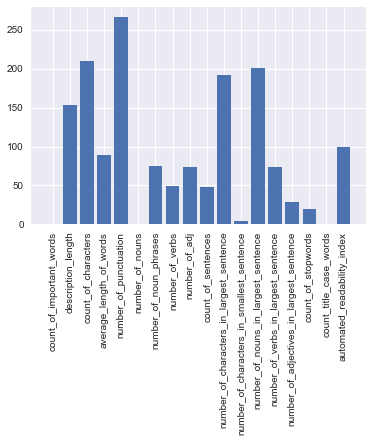

In [87]:
predictors = ['count_of_important_words', 'description_length',
       'count_of_characters', 'average_length_of_words',
       'number_of_punctuation', 'number_of_nouns', 'number_of_noun_phrases',
       'number_of_verbs', 'number_of_adj', 'count_of_sentences',
       'number_of_characters_in_largest_sentence',
       'number_of_characters_in_smallest_sentence',
       'number_of_nouns_in_largest_sentence',
       'number_of_verbs_in_largest_sentence',
       'number_of_adjectives_in_largest_sentence', 'count_of_stopwords',
       'count_title_case_words', 'automated_readability_index']
selector = SelectKBest(f_classif, k=5)
selector.fit(X_train, y_train)

print(selector.get_support())

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

In [108]:
kbest = SelectKBest(f_classif)
stdScaler = StandardScaler()
minmax = MinMaxScaler()
pipeline = Pipeline([('stdScaler', stdScaler), ('kbest', kbest), ('lr', LogisticRegression())])
grid_search = GridSearchCV(pipeline, {'kbest__k': [1,2,3,4,5, 6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'lr__C': [0.001,0.01,0.1,1,10,100,1000]}, cv = 5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('stdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x00000229C6ACA8C8>)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [109]:
print("Best parameters set found on development set:")
print()
print(grid_search.best_params_)
print()
print("Grid scores on development set:")
print()
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))
print()

Best parameters set found on development set:

{'kbest__k': 20, 'lr__C': 10}

Grid scores on development set:

0.693 (+/-0.021) for {'kbest__k': 1, 'lr__C': 0.001}
0.693 (+/-0.021) for {'kbest__k': 1, 'lr__C': 0.01}
0.693 (+/-0.021) for {'kbest__k': 1, 'lr__C': 0.1}
0.693 (+/-0.021) for {'kbest__k': 1, 'lr__C': 1}
0.693 (+/-0.021) for {'kbest__k': 1, 'lr__C': 10}
0.693 (+/-0.021) for {'kbest__k': 1, 'lr__C': 100}
0.693 (+/-0.021) for {'kbest__k': 1, 'lr__C': 1000}
0.698 (+/-0.010) for {'kbest__k': 2, 'lr__C': 0.001}
0.698 (+/-0.013) for {'kbest__k': 2, 'lr__C': 0.01}
0.699 (+/-0.015) for {'kbest__k': 2, 'lr__C': 0.1}
0.699 (+/-0.015) for {'kbest__k': 2, 'lr__C': 1}
0.699 (+/-0.015) for {'kbest__k': 2, 'lr__C': 10}
0.699 (+/-0.015) for {'kbest__k': 2, 'lr__C': 100}
0.699 (+/-0.015) for {'kbest__k': 2, 'lr__C': 1000}
0.694 (+/-0.009) for {'kbest__k': 3, 'lr__C': 0.001}
0.698 (+/-0.009) for {'kbest__k': 3, 'lr__C': 0.01}
0.698 (+/-0.009) for {'kbest__k': 3, 'lr__C': 0.1}
0.698 (+/-0.010) 

By scaling the data using the StandardScaler, the accuracy increased.

In [112]:
kbest = SelectKBest(f_classif)
stdScaler = StandardScaler()
pipeline = Pipeline([('stdScaler', stdScaler), ('kbest', kbest), ('clf', RandomForestClassifier())])
grid_search = GridSearchCV(pipeline, {'kbest__k': [1,2,3,4,5, 6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'clf__n_estimators': [5, 40, 42, 100], "clf__max_depth": [5, 6],
              "clf__min_samples_split": [5, 10],
              "clf__min_samples_leaf": [3, 5],
              "clf__max_leaf_nodes": [14, 15]}, cv = 5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('stdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x00000229C6ACA8C8>)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', ma...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'clf__n_estimators': [5, 40, 42, 100], 'clf__max_depth': [5, 6], 'clf__min_samples_split': [5, 10], 'clf__min_samples_leaf': [3, 5], 'clf__max_leaf_nodes': [14, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [113]:
print("Best parameters set found on development set:")
print()
print(grid_search.best_params_)
print()
print("Grid scores on development set:")
print()
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'clf__max_depth': 5, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 100, 'kbest__k': 20}

Grid scores on development set:

0.688 (+/-0.014) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 5, 'kbest__k': 1}
0.695 (+/-0.010) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 5, 'kbest__k': 2}
0.688 (+/-0.005) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 5, 'kbest__k': 3}
0.695 (+/-0.012) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 5, 'kbest__k': 4}
0.697 (+/-0.021) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min

0.721 (+/-0.009) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 5, 'kbest__k': 16}
0.711 (+/-0.002) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 5, 'kbest__k': 17}
0.715 (+/-0.011) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 5, 'kbest__k': 18}
0.715 (+/-0.020) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 5, 'kbest__k': 19}
0.718 (+/-0.008) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 5, 'kbest__k': 20}
0.691 (+/-0.019) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 40, 'kbest_

0.726 (+/-0.006) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 40, 'kbest__k': 12}
0.726 (+/-0.008) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 40, 'kbest__k': 13}
0.724 (+/-0.003) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 40, 'kbest__k': 14}
0.724 (+/-0.006) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 40, 'kbest__k': 15}
0.725 (+/-0.010) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 40, 'kbest__k': 16}
0.727 (+/-0.004) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 40, 'kbest__

0.720 (+/-0.010) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 42, 'kbest__k': 8}
0.728 (+/-0.007) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 42, 'kbest__k': 9}
0.728 (+/-0.009) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 42, 'kbest__k': 10}
0.724 (+/-0.005) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 42, 'kbest__k': 11}
0.728 (+/-0.010) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 42, 'kbest__k': 12}
0.724 (+/-0.008) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 42, 'kbe

0.696 (+/-0.011) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 100, 'kbest__k': 4}
0.703 (+/-0.011) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 100, 'kbest__k': 5}
0.705 (+/-0.011) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 100, 'kbest__k': 6}
0.723 (+/-0.007) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 100, 'kbest__k': 7}
0.724 (+/-0.007) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 100, 'kbest__k': 8}
0.727 (+/-0.004) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 100, 'kbest_

0.733 (+/-0.008) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 100, 'kbest__k': 20}
0.691 (+/-0.019) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 5, 'kbest__k': 1}
0.695 (+/-0.008) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 5, 'kbest__k': 2}
0.690 (+/-0.008) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 5, 'kbest__k': 3}
0.692 (+/-0.009) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 5, 'kbest__k': 4}
0.695 (+/-0.004) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 5, 'kbest__k': 5}


0.718 (+/-0.020) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 5, 'kbest__k': 17}
0.724 (+/-0.016) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 5, 'kbest__k': 18}
0.723 (+/-0.007) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 5, 'kbest__k': 19}
0.728 (+/-0.009) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 5, 'kbest__k': 20}
0.693 (+/-0.021) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 40, 'kbest__k': 1}
0.695 (+/-0.005) for {'clf__max_depth': 5, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 40, 'kbest_

0.726 (+/-0.010) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 40, 'kbest__k': 13}
0.728 (+/-0.006) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 40, 'kbest__k': 14}
0.725 (+/-0.009) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 40, 'kbest__k': 15}
0.725 (+/-0.011) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 40, 'kbest__k': 16}
0.724 (+/-0.008) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 40, 'kbest__k': 17}
0.730 (+/-0.004) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 40, 'kbest__

0.725 (+/-0.010) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 42, 'kbest__k': 9}
0.728 (+/-0.005) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 42, 'kbest__k': 10}
0.726 (+/-0.003) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 42, 'kbest__k': 11}
0.727 (+/-0.007) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 42, 'kbest__k': 12}
0.727 (+/-0.004) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 42, 'kbest__k': 13}
0.723 (+/-0.006) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 42, 'kb

0.703 (+/-0.014) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 100, 'kbest__k': 5}
0.703 (+/-0.010) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 100, 'kbest__k': 6}
0.723 (+/-0.008) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 100, 'kbest__k': 7}
0.725 (+/-0.008) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 100, 'kbest__k': 8}
0.727 (+/-0.006) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 100, 'kbest__k': 9}
0.730 (+/-0.005) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 14, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 100, 'kbest_

0.691 (+/-0.019) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 5, 'kbest__k': 1}
0.696 (+/-0.014) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 5, 'kbest__k': 2}
0.690 (+/-0.008) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 5, 'kbest__k': 3}
0.693 (+/-0.016) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 5, 'kbest__k': 4}
0.699 (+/-0.017) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 5, 'kbest__k': 5}
0.693 (+/-0.012) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 5, 'kbest__k': 6}
0.71

0.721 (+/-0.013) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 5, 'kbest__k': 18}
0.719 (+/-0.021) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 5, 'kbest__k': 19}
0.720 (+/-0.018) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 5, 'kbest__k': 20}
0.691 (+/-0.019) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 40, 'kbest__k': 1}
0.695 (+/-0.006) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 40, 'kbest__k': 2}
0.695 (+/-0.012) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 40, 'kbest_

0.724 (+/-0.008) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 40, 'kbest__k': 14}
0.724 (+/-0.008) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 40, 'kbest__k': 15}
0.727 (+/-0.015) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 40, 'kbest__k': 16}
0.726 (+/-0.011) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 40, 'kbest__k': 17}
0.725 (+/-0.007) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 40, 'kbest__k': 18}
0.730 (+/-0.009) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 40, 'kbest__

0.730 (+/-0.008) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 42, 'kbest__k': 10}
0.726 (+/-0.006) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 42, 'kbest__k': 11}
0.729 (+/-0.006) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 42, 'kbest__k': 12}
0.727 (+/-0.004) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 42, 'kbest__k': 13}
0.730 (+/-0.008) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 42, 'kbest__k': 14}
0.726 (+/-0.006) for {'clf__max_depth': 6, 'clf__max_leaf_nodes': 15, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 42, 'k

In [114]:
kbest = SelectKBest(f_classif)
stdScaler = StandardScaler()
pipeline = Pipeline([('kbest', kbest), ('stdScaler', stdScaler), ('clf', svm.SVC(kernel='linear'))])
grid_search = GridSearchCV(pipeline, {'kbest__k': [1,2,3,4,5, 6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'clf__C': [0.001, 0.01, 0.1, 1, 10], "clf__gamma": [0.001, 0.01, 0.1, 1]}, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x00000229C6ACA8C8>)), ('stdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'clf__C': [0.001, 0.01, 0.1, 1, 10], 'clf__gamma': [0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [115]:
print("Best parameters set found on development set:")
print()
print(grid_search.best_params_)
print()
print("Grid scores on development set:")
print()
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'clf__C': 10, 'clf__gamma': 0.001, 'kbest__k': 20}

Grid scores on development set:

0.691 (+/-0.013) for {'clf__C': 0.001, 'clf__gamma': 0.001, 'kbest__k': 1}
0.693 (+/-0.004) for {'clf__C': 0.001, 'clf__gamma': 0.001, 'kbest__k': 2}
0.693 (+/-0.003) for {'clf__C': 0.001, 'clf__gamma': 0.001, 'kbest__k': 3}
0.699 (+/-0.008) for {'clf__C': 0.001, 'clf__gamma': 0.001, 'kbest__k': 4}
0.700 (+/-0.011) for {'clf__C': 0.001, 'clf__gamma': 0.001, 'kbest__k': 5}
0.700 (+/-0.009) for {'clf__C': 0.001, 'clf__gamma': 0.001, 'kbest__k': 6}
0.716 (+/-0.006) for {'clf__C': 0.001, 'clf__gamma': 0.001, 'kbest__k': 7}
0.716 (+/-0.010) for {'clf__C': 0.001, 'clf__gamma': 0.001, 'kbest__k': 8}
0.716 (+/-0.008) for {'clf__C': 0.001, 'clf__gamma': 0.001, 'kbest__k': 9}
0.718 (+/-0.009) for {'clf__C': 0.001, 'clf__gamma': 0.001, 'kbest__k': 10}
0.719 (+/-0.012) for {'clf__C': 0.001, 'clf__gamma': 0.001, 'kbest__k': 11}
0.722 (+/-0.012) for {'clf__C': 0.001, '

0.700 (+/-0.003) for {'clf__C': 0.1, 'clf__gamma': 1, 'kbest__k': 3}
0.702 (+/-0.009) for {'clf__C': 0.1, 'clf__gamma': 1, 'kbest__k': 4}
0.703 (+/-0.009) for {'clf__C': 0.1, 'clf__gamma': 1, 'kbest__k': 5}
0.712 (+/-0.006) for {'clf__C': 0.1, 'clf__gamma': 1, 'kbest__k': 6}
0.722 (+/-0.012) for {'clf__C': 0.1, 'clf__gamma': 1, 'kbest__k': 7}
0.721 (+/-0.010) for {'clf__C': 0.1, 'clf__gamma': 1, 'kbest__k': 8}
0.722 (+/-0.014) for {'clf__C': 0.1, 'clf__gamma': 1, 'kbest__k': 9}
0.725 (+/-0.016) for {'clf__C': 0.1, 'clf__gamma': 1, 'kbest__k': 10}
0.726 (+/-0.015) for {'clf__C': 0.1, 'clf__gamma': 1, 'kbest__k': 11}
0.728 (+/-0.010) for {'clf__C': 0.1, 'clf__gamma': 1, 'kbest__k': 12}
0.729 (+/-0.012) for {'clf__C': 0.1, 'clf__gamma': 1, 'kbest__k': 13}
0.728 (+/-0.011) for {'clf__C': 0.1, 'clf__gamma': 1, 'kbest__k': 14}
0.728 (+/-0.011) for {'clf__C': 0.1, 'clf__gamma': 1, 'kbest__k': 15}
0.729 (+/-0.012) for {'clf__C': 0.1, 'clf__gamma': 1, 'kbest__k': 16}
0.729 (+/-0.012) for {'clf_

## Testing the parameter selection for the Logistic Regression model with the test set

In [117]:
# there is no particular reason in the choice of algorithms, just curiosity of performance
kbest = SelectKBest(f_classif, k=20)
stdScaler = StandardScaler()
pipeline = Pipeline([('kbest', kbest), ('stdScaler', stdScaler), ('clf', svm.SVC(kernel='linear', C = 10, gamma = 0.001))])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=20, score_func=<function f_classif at 0x00000229C6ACA8C8>)), ('stdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [118]:
logreg_prediction = pipeline.predict(X_test)

In [119]:
print('Logistic regression accuracy', accuracy_score(y_test, logreg_prediction))
print ('Logistic regression confusion matrix\n', confusion_matrix(y_test, logreg_prediction))
print ('(row=expected, col=predicted)')

Logistic regression accuracy 0.7525387493319081
Logistic regression confusion matrix
 [[574 293]
 [170 834]]
(row=expected, col=predicted)


In [120]:
list1 = ["Actual 0", "Actual 1"]
list2 = ["Predicted 0", "Predicted 1"]
pd.DataFrame(confusion_matrix(y_test, logreg_prediction), list1,list2)

,Predicted 0,Predicted 1
Actual 0,574,293
Actual 1,170,834


In [121]:
print(classification_report(y_test, logreg_prediction))

             precision    recall  f1-score   support

          0       0.77      0.66      0.71       867
          1       0.74      0.83      0.78      1004

avg / total       0.75      0.75      0.75      1871



# Testing the model with beer reviews

In [122]:
beer = pd.read_json('data/raw/beers.json')
beer = beer.copy()

In [123]:
processed_reviews = []
reviews = beer['description']
for review in reviews:
    processed_reviews.append(remove_stopwords(normalize(review)))

In [17]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df = 0.95, ngram_range=(1,2))
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_reviews)

In [18]:
# features holds a list of all the words in the tfidf's vocabulary in the same order as the column in the matrix
features = tfidf_vectorizer.get_feature_names()

In [19]:
weights = np.asarray(tfidf_matrix.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term':features, 'weights':weights})
weights_df = weights_df.sort_values(by='weights', ascending=False)

In [20]:
important_terms = weights_df['term'][:20].tolist()

In [21]:
def count_of_important_words(review):
    count = 0
    for word in normalize(review).split():
        if word in important_terms:
            count+=1
    return count

In [ ]:
beer['count_of_important_words'] = beer['description'].map(count_of_important_words)

In [82]:
beer['automated_readability_index'] = beer.apply(lambda x: automated_readability_index(x['count_of_characters'], x['description_length'], x['count_of_sentences']), axis = 1)

In [93]:
beer['count_of_adverbs'] = beer['description'].map(adv_getter)

In [101]:
beer['lexical_density'] = beer.apply(lambda x: lexical_density(x['number_of_nouns'], x['number_of_verbs'], x['number_of_adj'], x['count_of_adverbs'], x['description_length']), axis = 1)

In [22]:
beer['count_of_important_words'] = beer['description'].map(count_of_important_words)

In [ ]:
beer['description_length'] = beer['description'].apply(lambda text: len(str(text).split()))

beer['count_of_characters'] = beer['description'].apply(lambda text: len(text))

beer['average_length_of_words'] = beer['count_of_characters'] / beer['description_length']

beer['number_of_punctuation'] = beer['description'].map(punctuation_counter)

beer['number_of_nouns'] = beer['description'].map(noun_getter)

beer['number_of_noun_phrases'] = beer['description'].map(noun_chunks_getter)

beer['number_of_verbs'] = beer['description'].map(verb_getter)

beer['number_of_adj'] = beer['description'].map(adj_getter)

beer['count_of_sentences'] = beer['description'].map(count_sentences)

max_length_list = []
min_length_list = []
nouns_list = []
verb_list = []
adj_list = []

for review in beer['description']:
    d = find_sentence_length_with_pos_tags(review)
    max_length = ((max(k for k, v in d.items())))
    min_length_list.append((min(k for k, v in d.items())))
    noun_count, verb_count, adj_count = d[max_length]
    
    max_length_list.append(max_length)
    nouns_list.append(noun_count)
    verb_list.append(verb_count)
    adj_list.append(adj_count)

beer['number_of_characters_in_largest_sentence'] = max_length_list
beer['number_of_characters_in_smallest_sentence'] = min_length_list
beer['number_of_nouns_in_largest_sentence'] = nouns_list
beer['number_of_verbs_in_largest_sentence'] = verb_list
beer['number_of_adjectives_in_largest_sentence'] = adj_list

stop_words = set(stopwords.words('english'))
beer['count_of_stopwords'] = beer['description'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]) )

beer['count_of_upper_case_words'] = beer['description'].apply(lambda x: len([w for w in str(x).replace('I','i').replace('A','a').split() if w.isupper() == True]) )

beer['count_title_case_words'] = beer['description'].apply(lambda x: len([w for w in str(x).replace('I','i').replace('A','a').split() if w.istitle() == True]) )

In [ ]:
beer.drop(['description'], axis = 1, inplace = True)

In [ ]:
beer.drop(['country', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'taster_twitter_handle', 'title', 'variety', 'winery'], axis = 1, inplace=True)

In [ ]:
beer.drop('taster_name', axis =1, inplace=True)

In [ ]:
predictions = pipeline.predict(beer)

In [ ]:
y = np.bincount(predictions)
ii = np.nonzero(y)[0]

In [ ]:
list(zip(ii,y[ii]))